## Predict second year EPM from first year EPM for players in the 2020 NBA draft

Super simple model

```
epm_year_2 ~ epm_year_1 + (1|drafting_team)
```

This is a dead simple intro to numpyro.

See epm at [dunksandthrees.com](https://dunksandthrees.com/epm)

See numpyro docs [here](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#Posterior-Predictive-Distribution)

Note epm is in standard deviations

In [45]:
import polars as pl

import numpy as np
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import LabelEncoder
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
import matplotlib.pyplot as plt

s = numpyro.sample
d = numpyro.deterministic

In [46]:
df = pl.read_csv('2020_class.csv')

In [47]:
df.head()

name,epm1,epm2,team1
str,f64,f64,str
"""Aaron Nesmith""",-0.845899,-0.888998,"""BOS"""
"""Aleksej Pokuse…",-2.235338,-0.527809,"""OKC"""
"""Anthony Edward…",0.023772,1.180775,"""MIN"""
"""CJ Elleby""",-0.253226,-1.169969,"""POR"""
"""Cassius Stanle…",-1.842615,-0.888453,"""IND"""


In [48]:
team1_encoder = LabelEncoder()
df = df.with_columns(
    team1_code = pl.lit(team1_encoder.fit_transform(df['team1'].to_numpy())),
)

In [49]:
df.head()

name,epm1,epm2,team1,team1_code
str,f64,f64,str,i64
"""Aaron Nesmith""",-0.845899,-0.888998,"""BOS""",2
"""Aleksej Pokuse…",-2.235338,-0.527809,"""OKC""",18
"""Anthony Edward…",0.023772,1.180775,"""MIN""",15
"""CJ Elleby""",-0.253226,-1.169969,"""POR""",22
"""Cassius Stanle…",-1.842615,-0.888453,"""IND""",10


In [50]:
rng_key, rng_key_predict = random.split(random.PRNGKey(42))
epm2 = df['epm2'].to_numpy()
epm1 = df['epm1'].to_numpy()

team1 = df['team1_code'].to_numpy()

In [51]:
def model(epm1, team1, epm2=None):
    n_team1 = len(np.unique(team1))

    intercept = s('intercept', dist.Normal(0, 1))
    sigma = s('sigma', dist.Exponential(1))
    sigma_team1 = s('sigma_team1', dist.Exponential(1))

    epm1_beta = s('epm1_beta', dist.Normal(0, 1))
    with numpyro.plate('team1', n_team1):
        z_team1 = s('z_team1', dist.Normal(0, 1))
        beta_team1 = z_team1 * sigma_team1

    yhat = intercept + epm1_beta * epm1 + beta_team1[team1]
    s('obs', dist.Normal(loc=yhat, scale=sigma), obs=epm2)

In [52]:
kernel = NUTS(model)
mcmc = MCMC(
    kernel,
    num_warmup=500,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
)
mcmc.run(
    rng_key,
    epm1,
    team1,
    epm2,
)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:01<00:00, 1255.53it/s, 15 steps of size 3.17e-01. acc. prob=0.88]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
    epm1_beta      0.54      0.17      0.54      0.28      0.82    872.36      1.01
    intercept      0.07      0.18      0.07     -0.25      0.35    901.86      1.00
        sigma      0.83      0.10      0.83      0.68      1.00   1331.13      1.00
  sigma_team1      0.20      0.15      0.18      0.00      0.41    533.69      1.00
   z_team1[0]     -0.09      0.94     -0.08     -1.67      1.47   2062.98      1.00
   z_team1[1]      0.16      0.95      0.20     -1.31      1.74   1537.41      1.00
   z_team1[2]     -0.05      0.94     -0.03     -1.57      1.54   2567.52      1.00
   z_team1[3]      0.32      0.98      0.36     -1.22      1.91   1473.27      1.00
   z_team1[4]     -0.01      1.00     -0.02     -1.69      1.63   2041.91      1.00
   z_team1[5]      0.08      0.96      0.13     -1.63      1.51   1637.29      1.00
   z_team1[6]      0.05      0.99      0.06     -1.47      1.77   2111.57  

In [53]:
samples = mcmc.get_samples()

In [54]:
samples

{'epm1_beta': Array([ 6.52145743e-01,  4.72067207e-01,  5.42204976e-01,  7.39420354e-01,
         5.88542640e-01,  2.34645635e-01,  3.44383419e-01,  6.41557217e-01,
         3.86315256e-01,  6.59118056e-01,  6.31628573e-01,  6.09433174e-01,
         5.78881443e-01,  6.13198757e-01,  5.96910119e-01,  5.05795300e-01,
         4.19338793e-01,  3.90168428e-01,  6.12426579e-01,  6.64350510e-01,
         5.30680537e-01,  3.75006527e-01,  5.69573164e-01,  4.19151992e-01,
         7.18649864e-01,  3.98581862e-01,  3.79532486e-01,  4.76537168e-01,
         6.65680587e-01,  7.02221453e-01,  4.67091650e-01,  5.62868774e-01,
         5.49232483e-01,  3.50663304e-01,  2.91449994e-01,  6.95314407e-01,
         3.33492041e-01,  3.68739963e-01,  5.02134800e-01,  4.68519747e-01,
         7.09848702e-01,  5.29372931e-01,  5.68512976e-01,  4.21904564e-01,
         4.71635073e-01,  7.21013010e-01,  7.48027325e-01,  6.09313548e-01,
         4.42093402e-01,  5.11193693e-01,  4.70102102e-01,  8.93111050e-01,

In [55]:
predictive = Predictive(model, samples)

In [56]:
rng_key, rng_key_ = random.split(rng_key)

In [57]:
predictions = predictive(rng_key_, epm1=epm1, team1=team1)['obs']

In [58]:
predictions

Array([[-8.0471748e-01, -1.3130008e+00,  9.1489084e-02, ...,
        -3.1371802e-01, -1.4440560e-01, -1.5579292e+00],
       [-1.3788025e+00, -7.1832198e-01, -3.1860501e-01, ...,
        -5.6618506e-01, -2.8078110e+00, -2.7238906e-03],
       [-4.7004238e-01, -9.5895338e-01,  1.8318501e+00, ...,
        -9.3303615e-01, -1.0221229e+00, -2.6932185e+00],
       ...,
       [-8.1560916e-01, -9.4071847e-01, -4.3858463e-01, ...,
         8.6024475e-01, -2.3655670e+00, -2.1052046e+00],
       [ 1.3623467e-01, -1.1763079e+00,  5.1214057e-01, ...,
        -6.8867403e-01, -2.3919649e+00,  1.0226215e-01],
       [ 5.7421554e-02, -7.3823833e-01, -2.0606656e-01, ...,
         3.4481233e-01, -9.7540557e-01,  2.0245087e+00]], dtype=float32)

In [59]:
means = jnp.mean(predictions, axis=0)
hpdis = hpdi(predictions, 0.8)

In [60]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    first_year_epm = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    second_year_epm = epm2[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(first_year_epm, mean)
    ax.plot(first_year_epm, second_year_epm, "o")
    ax.fill_between(first_year_epm, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

[Text(0.5, 0, 'First Year EPM'),
 Text(0, 0.5, 'Second Year EPM'),
 Text(0.5, 1.0, 'Predictions with 80% CI')]

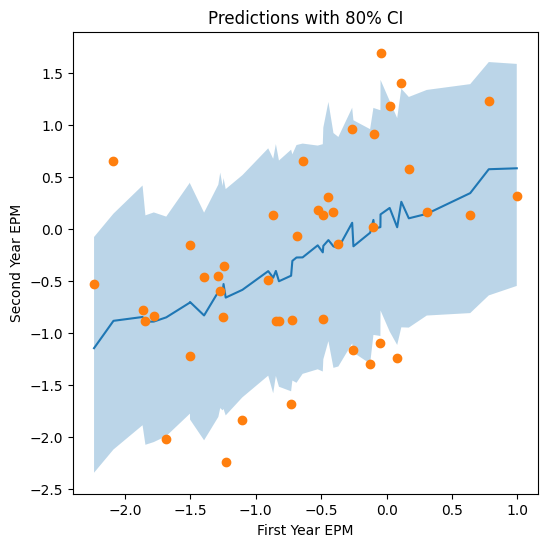

In [61]:
ax = plot_regression(epm1, means, hpdis)
ax.set(xlabel="First Year EPM", ylabel="Second Year EPM", title="Predictions with 80% CI")

In [71]:
# what's the R^2?
# 0.3, not bad!!

1 - jnp.sum((epm2 - means) ** 2) / jnp.sum((epm2 - jnp.mean(epm2)) ** 2)

Array(0.30112702, dtype=float32)